In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torchvision import models, transforms
from torch.nn.functional import mse_loss
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#Parametters
H=350
W=300

### Preprocessing

In [4]:
transform=transforms.Compose([
    transforms.Resize((H,W)),
    transforms.ToTensor(),
])

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
os.listdir('gdrive')

['MyDrive',
 'Othercomputers',
 '.shortcut-targets-by-id',
 '.file-revisions-by-id',
 '.Trash-0',
 '.Encrypted']

In [7]:
path='gdrive/MyDrive/Colab Notebooks'
os.listdir(path)

['kalapa.ipynb',
 'kalapaN.ipynb',
 'target.jpg',
 'pisca.jpg',
 'style1.jpg',
 'content.jpg',
 'style transfer',
 'style2.jpg',
 'Transfert Learning.ipynb',
 'van.jpg']

In [8]:
content_img=Image.open(path+'/content.jpg')
content_trans=transform(content_img)

In [9]:
style_img=Image.open(path+'/style2.jpg')
style_trans=transform(style_img)

In [10]:
style_trans.size()

torch.Size([3, 350, 300])

In [11]:
content_input=torch.unsqueeze(content_trans,0).to(device)
style_input=torch.unsqueeze(style_trans,0).to(device)

In [12]:
content_input.size()

torch.Size([1, 3, 350, 300])

### Model

In [13]:
model=models.vgg19(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [15]:
layer1=model.features._modules['0']
layer1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [16]:
content_input.size()

torch.Size([1, 3, 350, 300])

In [17]:
layer1(content_input).size()

torch.Size([1, 64, 350, 300])

In [18]:
model.features[25]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

### Extract features

In [19]:
content_layers=[28]
style_layers=[0, 5, 10, 19, 28 ]
layer_idx=max(content_layers+style_layers)+1

In [20]:
model.features[25]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [21]:
def extract_features(model, X, content_layers, style_layers, with_grad):
  if with_grad:
    contents=[]
    styles=[]
    for i in range(layer_idx):
      X=model.features[i](X)
      if i in content_layers:
        contents.append(X)
      if i in style_layers:
        styles.append(X)
    return contents, styles
  else:
    with torch.no_grad():
      contents=[]
      styles=[]
      for i in range(layer_idx):
        X=model.features[i](X)
        if i in content_layers:
          contents.append(X)
        if i in style_layers:
          styles.append(X)
      return contents, styles


In [22]:
content_features,_=extract_features(model, content_input, content_layers, style_layers, False)
_,style_features=extract_features(model, style_input, content_layers, style_layers, False)

In [23]:
print(content_features[0].size())
print(style_features[0].size())

torch.Size([1, 512, 21, 18])
torch.Size([1, 64, 350, 300])


### Gram matrix

In [24]:
def Gram_matrix(tensor):
  _,c,h,w=tensor.size()
  dim=h*w
  matrix=tensor.view(c, dim)
  gram_matrix=torch.mm(matrix, matrix.t())
  return gram_matrix/(c*dim)

In [25]:
style_gram_matrix=[Gram_matrix(x) for x in style_features]

### Training

In [26]:
weights=torch.tensor([0.8,0.6,0.4,0.2,0.1])
alpha=1
beta=1e8
target=content_input.requires_grad_(True).to(device)
opt=torch.optim.Adam([target], lr=0.02)

In [27]:
resultat=[]
Loss=[]
for i in range(1001):
  #Gradient_zero
  opt.zero_grad()
  #Target features
  target_content, target_style=extract_features(model, target, content_layers, style_layers, True) #Caculate the target_content and target_style
  #Forward
  content_loss=nn.functional.mse_loss(content_features[0], target_content[0])  #Content loss
  target_gram_matrix=[Gram_matrix(x) for x in target_style]  #Gram matrix of target style
  style_loss=0
  for w in range(len(weights)):
    layer_loss=nn.functional.mse_loss(style_gram_matrix[w], target_gram_matrix[w])*weights[w] #Style loss with weights
    style_loss+=layer_loss
  total_loss=alpha*content_loss+beta*style_loss #Total loss
  #Backward
  total_loss.backward()
  #Update
  opt.step()
  Loss.append(total_loss.item())
  if i%100==0:
    resultat.append(target)
    print(f'Iteration {i}, Content loss {content_loss}, Style loss {style_loss}, Total loss {total_loss}.')



Iteration 0, Content loss 0.0, Style loss 6.950585884624161e-06, Total loss 695.05859375.
Iteration 100, Content loss 8.3361177444458, Style loss 8.714405197451924e-08, Total loss 17.050521850585938.
Iteration 200, Content loss 7.947911262512207, Style loss 5.555270377044508e-08, Total loss 13.503181457519531.
Iteration 300, Content loss 7.767442226409912, Style loss 5.2040100229078234e-08, Total loss 12.971452713012695.
Iteration 400, Content loss 7.4823994636535645, Style loss 3.8576477123797304e-08, Total loss 11.340046882629395.
Iteration 500, Content loss 7.45997953414917, Style loss 3.6509113954252825e-08, Total loss 11.110891342163086.
Iteration 600, Content loss 7.388782978057861, Style loss 3.9140232388490404e-08, Total loss 11.30280590057373.
Iteration 700, Content loss 7.282983303070068, Style loss 3.164950612699613e-08, Total loss 10.4479341506958.
Iteration 800, Content loss 9.471905708312988, Style loss 1.591148702573264e-06, Total loss 168.58677673339844.
Iteration 900, 

In [28]:
def show_target(tensor):
  tensor=tensor.cpu()
  img=tensor.squeeze()
  img=img.detach().numpy()
  img=img.transpose(1,2,0)
  img = img.clip(0, 1)
  return img


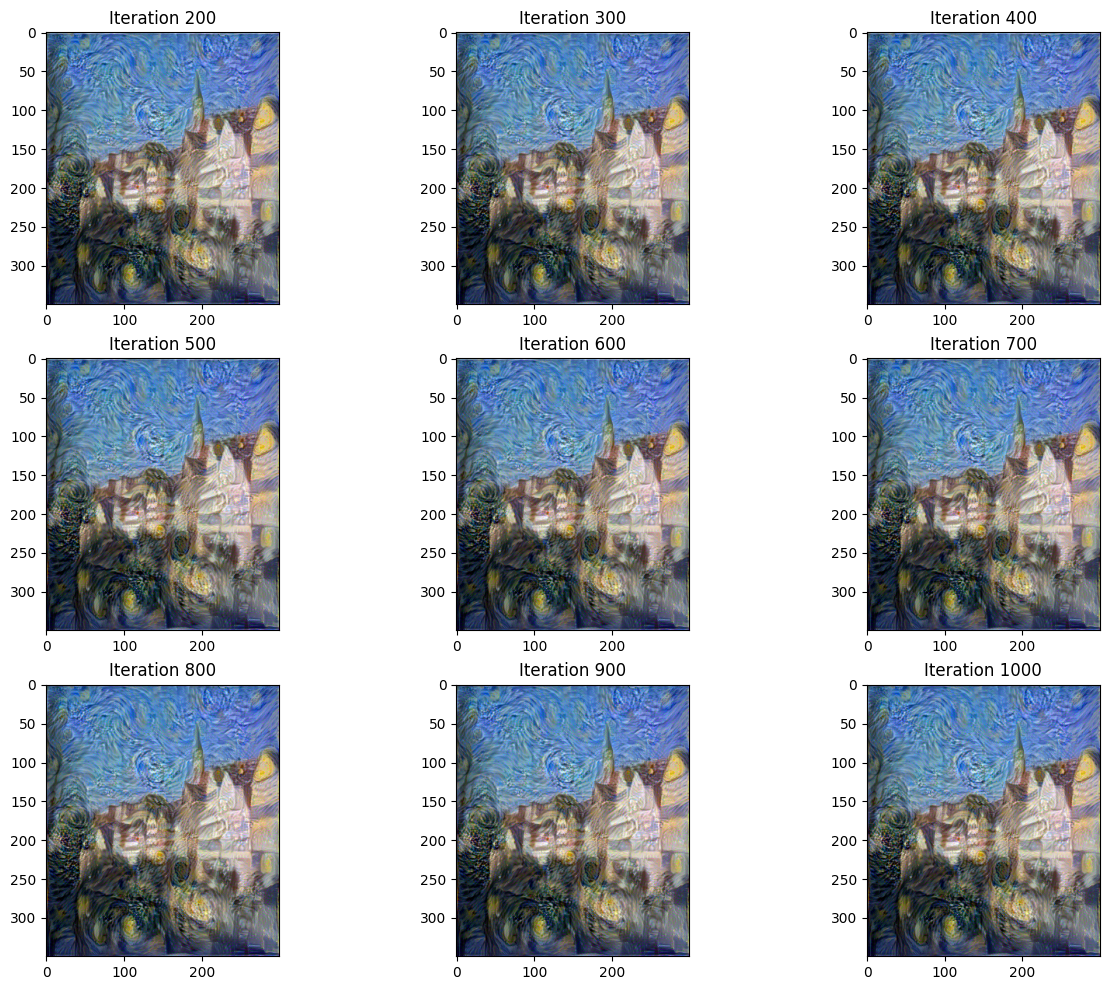

In [29]:
plt.figure(figsize=(15,12))
for i in range(2,len(resultat)):
  plt.subplot(3,3,i-1)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {100*i}')


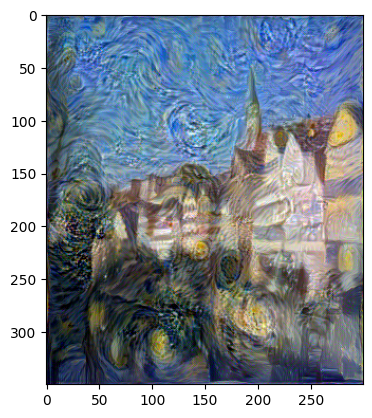

In [30]:
plt.imshow(show_target(resultat[10]))